# Importing Libraries

Here you will find all librairies needed to run the code

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from datetime import datetime, timedelta

# Importing data

In [3]:
df=pd.read_csv(r"C:\Users\olilo\Downloads\Nat_Gas.csv")

# Data Visualization


Our dataset contains gas price from 10/31/2020 to 9/30/2023
Let have have a look at its graph to see any variation in prices through the 3 years

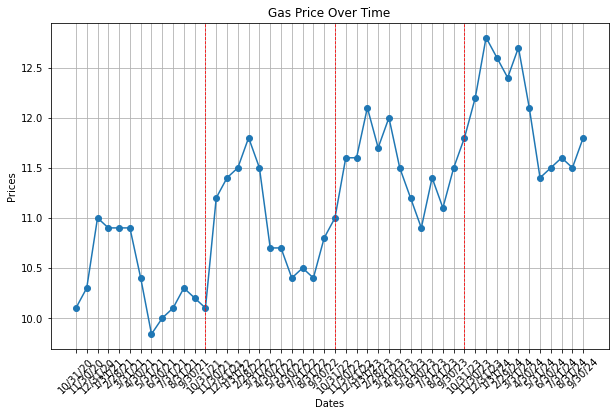

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['Dates'], df['Prices'], marker='o')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Gas Price Over Time')
plt.xticks(rotation=45)
plt.grid(True)

# Adding vertical lines every 12 months with a different color (e.g., red)
for i in range(12, len(df), 12):
    plt.axvline(df['Dates'].iloc[i], color='red', linestyle='--', linewidth=0.8)

plt.show()

We can observe an increase in price starting in august through january which may be due to the start of school year year and end of the year festivities such as (thanksgiving , chritsmas and new years eve) and a decrease in price starting in february through july

I believe there is some seasonal decomposition in the dataset , so we can have a deep loop on the decompostion components

<Figure size 2880x1440 with 0 Axes>

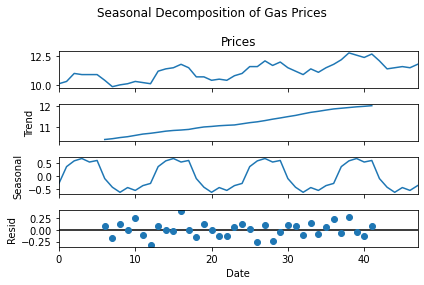

In [5]:
# Seasonal decomposition
decomposition = sm.tsa.seasonal_decompose(df['Prices'], model='additive',period=12)

# Plot the decomposition components
plt.figure(figsize=(40, 20))
decomposition.plot()
plt.xlabel('Date')
plt.suptitle('Seasonal Decomposition of Gas Prices')
plt.tight_layout()
plt.show()

The graph below confirm the seasonal pattern and an increase trend  in price

# Autoregression visualization


Now we can visualize the autoregression and check for stationary or non-stationary of the data

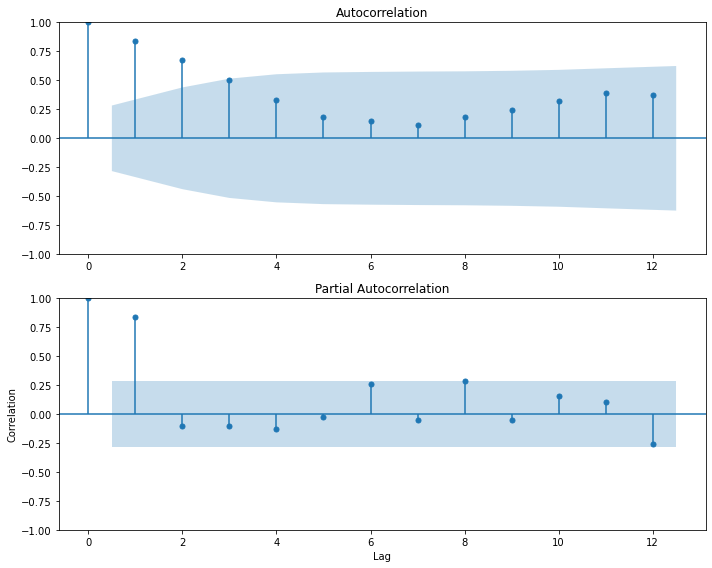

In [6]:
# Plot autocorrelation and partial autocorrelation plots
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
plot_acf(df['Prices'], ax=ax[0], lags=12)
plot_pacf(df['Prices'], ax=ax[1], lags=12)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

# Stationary

In [7]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'   {key}: {value}')

test_stationarity(df['Prices'])

ADF Statistic: 0.21807686170000343
p-value: 0.9732574388448695
Critical Values:
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


the p-value =0.97 greater than 0.05 which conclude that the we have a non stationary time series,
we will now apply first-order differencing to overcome this problem

In [8]:
# Perform first-order differencing
df['Prices_diff'] = df['Prices'].diff()

# Handle missing values and infinite values
df['Prices_diff'].replace([np.inf, -np.inf], np.nan, inplace=True)
df['Prices_diff'].fillna(method='ffill', inplace=True)

# Drop any remaining missing values (if any)
df.dropna(inplace=True)

# Check for stationarity after handling missing and infinite values
test_stationarity(df['Prices_diff'])

ADF Statistic: -6.844773557477349
p-value: 1.7541696852940399e-09
Critical Values:
   1%: -3.6209175221605827
   5%: -2.9435394610388332
   10%: -2.6104002410518627


After the first-order differncing , we now have a stationary times series

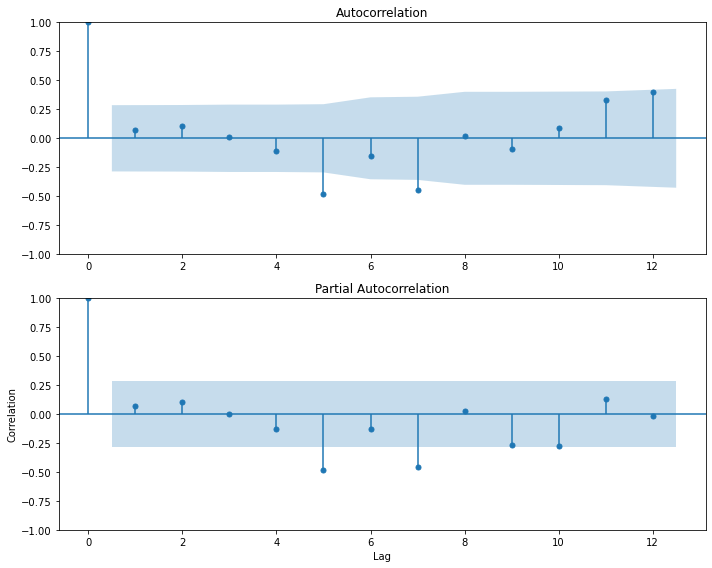

In [24]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 8))
plot_acf(df['Prices_diff'], ax=ax[0], lags=12)
plot_pacf(df['Prices_diff'], ax=ax[1], lags=12)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.tight_layout()
plt.show()

# Times series model


I will use the prices diff data to build the arima model. Since we have the same pattern every 12 months i took p=12. The model will forcast 12 months in the future since the last price.

In [9]:
# Build ARIMA model on the differenced series
model = ARIMA(df['Prices_diff'], order=(12,0 , 0))  
results = model.fit()

# Generate forecasts
forecast_steps = 12  # Number of steps to forecast
forecast_diff = results.forecast(steps=forecast_steps)
forecast_original = forecast_diff.cumsum() + df['Prices'].iloc[-1]

# Create a DataFrame for forecasts
forecast_dates = pd.date_range(start=df['Dates'].iloc[-1], periods=forecast_steps + 1, freq='M')[1:]
forecast_df = pd.DataFrame({'Dates': forecast_dates, 'Forecasted_Prices': forecast_original})

# Display the results
print("Historical Data:")
print(df[['Dates', 'Prices']])

print("\nForecasted Gas Prices for the Next 12 Months:")
print(forecast_df)

C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Historical Data:
       Dates  Prices
1   11/30/20   10.30
2   12/31/20   11.00
3    1/31/21   10.90
4    2/28/21   10.90
5    3/31/21   10.90
6    4/30/21   10.40
7    5/31/21    9.84
8    6/30/21   10.00
9    7/31/21   10.10
10   8/31/21   10.30
11   9/30/21   10.20
12  10/31/21   10.10
13  11/30/21   11.20
14  12/31/21   11.40
15   1/31/22   11.50
16   2/28/22   11.80
17   3/31/22   11.50
18   4/30/22   10.70
19   5/31/22   10.70
20   6/30/22   10.40
21   7/31/22   10.50
22   8/31/22   10.40
23   9/30/22   10.80
24  10/31/22   11.00
25  11/30/22   11.60
26  12/31/22   11.60
27   1/31/23   12.10
28   2/28/23   11.70
29   3/31/23   12.00
30   4/30/23   11.50
31   5/31/23   11.20
32   6/30/23   10.90
33   7/31/23   11.40
34   8/31/23   11.10
35   9/30/23   11.50
36  10/31/23   11.80
37  11/30/23   12.20
38  12/31/23   12.80
39   1/31/24   12.60
40   2/29/24   12.40
41   3/31/24   12.70
42   4/30/24   12.10
43   5/31/24   11.40
44   6/30/24   11.50
45   7/31/24   11.60
46   8/31/24   11

C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\olilo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [10]:
# Your code for generating historical and forecasted data here

# Convert historical dates to mm/dd/yy format
df['Dates'] = pd.to_datetime(df['Dates'])
df['Dates'] = df['Dates'].dt.strftime('%m/%d/%y')

# Convert forecast dates to datetime format and then to mm/dd/yy format
forecast_df['Dates'] = pd.to_datetime(forecast_df['Dates'])
forecast_df['Dates'] = forecast_df['Dates'].dt.strftime('%m/%d/%y')

# Combine historical and forecasted data into a single DataFrame
combined_df = pd.concat([df, forecast_df.rename(columns={'Forecasted_Prices': 'Prices'})], ignore_index=True)

# Drop the 'Prices_diff' column from the combined DataFrame
combined_df = combined_df.drop(columns=['Prices_diff'])

# Display the combined results
print("Combined Historical Data and Forecasted Gas Prices:")
print(combined_df)

Combined Historical Data and Forecasted Gas Prices:
       Dates     Prices
0   11/30/20  10.300000
1   12/31/20  11.000000
2   01/31/21  10.900000
3   02/28/21  10.900000
4   03/31/21  10.900000
5   04/30/21  10.400000
6   05/31/21   9.840000
7   06/30/21  10.000000
8   07/31/21  10.100000
9   08/31/21  10.300000
10  09/30/21  10.200000
11  10/31/21  10.100000
12  11/30/21  11.200000
13  12/31/21  11.400000
14  01/31/22  11.500000
15  02/28/22  11.800000
16  03/31/22  11.500000
17  04/30/22  10.700000
18  05/31/22  10.700000
19  06/30/22  10.400000
20  07/31/22  10.500000
21  08/31/22  10.400000
22  09/30/22  10.800000
23  10/31/22  11.000000
24  11/30/22  11.600000
25  12/31/22  11.600000
26  01/31/23  12.100000
27  02/28/23  11.700000
28  03/31/23  12.000000
29  04/30/23  11.500000
30  05/31/23  11.200000
31  06/30/23  10.900000
32  07/31/23  11.400000
33  08/31/23  11.100000
34  09/30/23  11.500000
35  10/31/23  11.800000
36  11/30/23  12.200000
37  12/31/23  12.800000
38  01/31/24

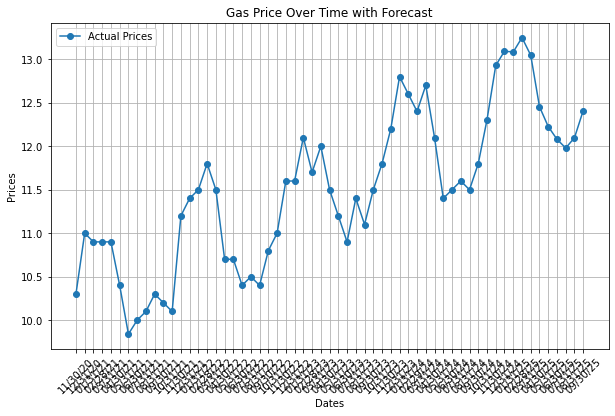

In [11]:
# Plot the combined data
plt.figure(figsize=(10, 6))
plt.plot(combined_df['Dates'], combined_df['Prices'], marker='o', label='Actual Prices')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Gas Price Over Time with Forecast')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


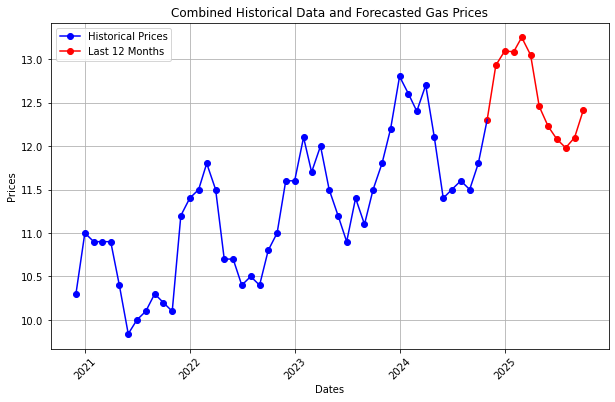

In [27]:
# Set the 'Dates' column as the index
combined_df['Dates'] = pd.to_datetime(combined_df['Dates'])
combined_df.set_index('Dates', inplace=True)

# Plot the combined data
plt.figure(figsize=(10, 6))

# Plot the historical data (in blue)
plt.plot(combined_df[:-12].index, combined_df[:-12]['Prices'], marker='o', label='Historical Prices', color='blue')

# Plot the last 12 observations (in red)
plt.plot(combined_df[-12:].index, combined_df[-12:]['Prices'], marker='o', label='Last 12 Months', color='red')

# Connect the lines between the last historical point and the first forecasted point
plt.plot([combined_df.index[-13], combined_df.index[-12]], 
         [combined_df['Prices'].iloc[-13], combined_df['Prices'].iloc[-12]], color='blue')

plt.xlabel('Dates')
plt.ylabel('Prices')
plt.title('Combined Historical Data and Forecasted Gas Prices')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.show()


Here , i will add the forecast value to the inital one data in order to plot it 

At the end of the modeling and plotting we can see that the model really learn from the increasing patter of the gas price . One may decided to check for the model performance using the mean absolute error or Root mean squared erroror may conclude we dont have enough data for a better prediction

In [12]:

# Calculate Mean Absolute Error (MAE)
mae = np.mean(np.abs(residuals))

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(np.mean(residuals ** 2))



NameError: name 'residuals' is not defined

In [13]:
mae

NameError: name 'mae' is not defined

In [93]:
rmse>

SyntaxError: invalid syntax (<ipython-input-93-a1eb0331879c>, line 1)

In [14]:
combined_df['Dates'] = pd.to_datetime(combined_df['Dates'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59 entries, 0 to 58
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Dates   59 non-null     datetime64[ns]
 1   Prices  59 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.0 KB


In [17]:
# Sample injection and withdrawal date pairs (replace with actual dates)
injection_dates = [pd.Timestamp('12/31/20')]
injection_volumes =100
withdrawal_dates = [pd.Timestamp('01/31/25')]  # Match the format
withdrawal_volumes = 70  # Example withdrawal rate (MMBtu/day)
today_dates=[pd.Timestamp('08/31/25')]

max_volume = 500    # Example maximum storage volume (MMBtu)
storage_cost = 100000  # Example monthly storage cost ($)
injection_withdrawal_cost = 10000  # Example injection/withdrawal cost per million MMBtu ($)
transportation_cost = 50000

# Calculate net volume
net_volume = injection_volumes - withdrawal_volumes
# Find the corresponding prices for injection and withdrawal dates
purchase_price = combined_df[combined_df['Dates'] == injection_dates[0].strftime('%m/%d/%y')]['Prices'].values[0]
sale_price = combined_df[combined_df['Dates'] == withdrawal_dates[0].strftime('%m/%d/%y')]['Prices'].values[0]
today_price=combined_df[combined_df['Dates'] == today_dates[0].strftime('%m/%d/%y')]['Prices'].values[0]

# Initialize estimated contract value
estimated_contract_value = 0

# Calculate the number of months between the first injection date and today's date
months_between_dates = (today_dates[0].year - injection_dates[0].year) * 12 + (today_dates[0].month - injection_dates[0].month)


# Calculate revenue from sale
revenue_from_sale = (withdrawal_volumes * sale_price)*1000000 - \
                    injection_withdrawal_cost - transportation_cost

# Calculate expense from purchase
expense_from_purchase = (injection_volumes * purchase_price)*1000000 + \
                        injection_withdrawal_cost + transportation_cost

# Calculate the total storage cost
total_storage_cost = months_between_dates * storage_cost

# Calculate asset value
asset_value = (net_volume * today_price)*1000000 - injection_withdrawal_cost - transportation_cost - total_storage_cost

# Calculate net cash flow
net_cash_flow = asset_value + revenue_from_sale - expense_from_purchase

# Print estimated contract value
print("Estimated Contract Value:", net_cash_flow)



Estimated Contract Value: 172966949.30233455


In [19]:
import pandas as pd
import numpy as np

# Sample injection and withdrawal date pairs (replace with actual dates)
injection_dates = [pd.Timestamp('12/31/20'), pd.Timestamp('03/31/21')]
injection_volumes = [100, 150]  # Volumes corresponding to each injection date
withdrawal_dates = [pd.Timestamp('01/31/25'), pd.Timestamp('04/30/25')]
withdrawal_volumes = [70, 80]  # Volumes corresponding to each withdrawal date
today_dates = [pd.Timestamp('08/31/25')]

max_volume = 500  # Example maximum storage volume (MMBtu)
storage_cost = 100000  # Example monthly storage cost ($)
injection_withdrawal_cost = 10000  # Example injection/withdrawal cost per million MMBtu ($)
transportation_cost = 50000

# Initialize estimated contract value
estimated_contract_value = 0

# Calculate net volume
net_volume = sum(injection_volumes) - sum(withdrawal_volumes)

# Check if the total injected volume exceeds the maximum storage volume
if net_volume > max_volume:
    print("Error: Total injected volume exceeds maximum storage volume.")
else:
    # Initialize variables to store purchase prices and sale prices for each injection and withdrawal date
    purchase_prices = []
    sale_prices = []

    # Find the corresponding purchase prices for each injection date
    for inj_date in injection_dates:
        price = combined_df[combined_df['Dates'] == inj_date.strftime('%m/%d/%y')]['Prices'].values[0]
        purchase_prices.append(price)

    # Find the corresponding sale prices for each withdrawal date
    for wd_date in withdrawal_dates:
        price = combined_df[combined_df['Dates'] == wd_date.strftime('%m/%d/%y')]['Prices'].values[0]
        sale_prices.append(price)

    # Find the purchase price for today's date
    today_price = combined_df[combined_df['Dates'] == today_dates[0].strftime('%m/%d/%y')]['Prices'].values[0]

    # Calculate revenue from sale for each withdrawal
    revenue_from_sale = sum([wd_vol * price * 1000000 for wd_vol, price in zip(withdrawal_volumes, sale_prices)]) - \
                        len(withdrawal_dates) * injection_withdrawal_cost - transportation_cost

    # Calculate expense from purchase for each injection
    expense_from_purchase = -sum([inj_vol * price * 1000000 for inj_vol, price in zip(injection_volumes, purchase_prices)]) + \
                            len(injection_dates) * injection_withdrawal_cost + transportation_cost

    # Calculate the number of months between the first injection date and today's date
    months_between = (today_dates[0].year - injection_dates[0].year) * 12 + (today_dates[0].month - injection_dates[0].month)

    # Calculate Asset Value including storage cost
    asset_value = (net_volume * today_price) * 1000000 - injection_withdrawal_cost - transportation_cost - (storage_cost * months_between)

    # Calculate net cash flow
    net_cash_flow = asset_value + revenue_from_sale - expense_from_purchase

    # Print estimated contract value
    print("Estimated Contract Value:", net_cash_flow)


Estimated Contract Value: 5851151308.839836


In [23]:
# Sample injection and withdrawal date pairs
injection_dates = [pd.Timestamp('12/31/20'), pd.Timestamp('03/31/25')]
injection_volumes = [100, 350]  # Volumes corresponding to each injection date
withdrawal_dates = [pd.Timestamp('01/31/25'), pd.Timestamp('04/30/25')]
withdrawal_volumes = [70, 80]  # Volumes corresponding to each withdrawal date
today_dates = [pd.Timestamp('08/31/25')]

max_volume = 500  # Example maximum storage volume (MMBtu)

# Initialize variables
current_volume = 0
exceeds_max_volume = False

# Combine and sort injection and withdrawal dates
all_dates = sorted(injection_dates + withdrawal_dates)

# Process transactions in chronological order
for date in all_dates:
    # Check if it's an injection date
    if date in injection_dates:
        index = injection_dates.index(date)
        current_volume += injection_volumes[index]
    # Check if it's a withdrawal date
    if date in withdrawal_dates:
        index = withdrawal_dates.index(date)
        current_volume -= withdrawal_volumes[index]

    # Check if the current volume exceeds the maximum storage volume
    if current_volume > max_volume:
        exceeds_max_volume = True
        break

    # Check if the current volume becomes negative (exceeds the injected volume)
    if current_volume < 0:
        exceeds_max_volume = True
        break

# If at any point the volume exceeded the maximum storage volume or went negative, set the flag to True
if exceeds_max_volume:
    print("Error: Total injected volume exceeds maximum storage volume.")
else:
    # Initialize variables to store purchase prices and sale prices for each injection and withdrawal date
    purchase_prices = []
    sale_prices = []

    # Find the corresponding purchase prices for each injection date
    for inj_date in injection_dates:
        price = combined_df[combined_df['Dates'] == inj_date.strftime('%m/%d/%y')]['Prices'].values[0]
        purchase_prices.append(price)

    # Find the corresponding sale prices for each withdrawal date
    for wd_date in withdrawal_dates:
        price = combined_df[combined_df['Dates'] == wd_date.strftime('%m/%d/%y')]['Prices'].values[0]
        sale_prices.append(price)

    # Find the purchase price for today's date
    today_price = combined_df[combined_df['Dates'] == today_dates[0].strftime('%m/%d/%y')]['Prices'].values[0]

    # Calculate revenue from sale for each withdrawal
    revenue_from_sale = sum([wd_vol * price * 1000000 for wd_vol, price in zip(withdrawal_volumes, sale_prices)]) - \
                        len(withdrawal_dates) * injection_withdrawal_cost - transportation_cost

    # Calculate expense from purchase for each injection
    expense_from_purchase = -sum([inj_vol * price * 1000000 for inj_vol, price in zip(injection_volumes, purchase_prices)]) + \
                            len(injection_dates) * injection_withdrawal_cost + transportation_cost

    # Calculate the number of months between the first injection date and today's date
    months_between = (today_dates[0].year - injection_dates[0].year) * 12 + (today_dates[0].month - injection_dates[0].month)

    # Calculate Asset Value including storage cost
    asset_value = (net_volume * today_price) * 1000000 - injection_withdrawal_cost - transportation_cost - (storage_cost * months_between)

    # Calculate net cash flow
    net_cash_flow = asset_value + revenue_from_sale - expense_from_purchase

    # Print estimated contract value
    print("Estimated Contract Value:", net_cash_flow)



Estimated Contract Value: 8782273283.986824


56